Kurtosis values:
fetal_clean           3.232511
maternal_clean        4.861408
maternal_shifted_1    4.861408
maternal_shifted_2    4.861408
fetal_noisy_1         3.305378
fetal_noisy_2         1.028322
fetal_noisy_3         0.656558
ecg_sum_no_noise_1    0.146504
ecg_sum_no_noise_2    1.454049
ecg_sum_noise_1       4.812772
ecg_sum_noise_2       1.224647
ecg_sum_noise_3       0.522816
ecg_sum_noise_4       4.887598
ecg_sum_noise_5       0.861831
ecg_sum_noise_6       0.515913
dtype: float64


<Figure size 1500x2000 with 0 Axes>

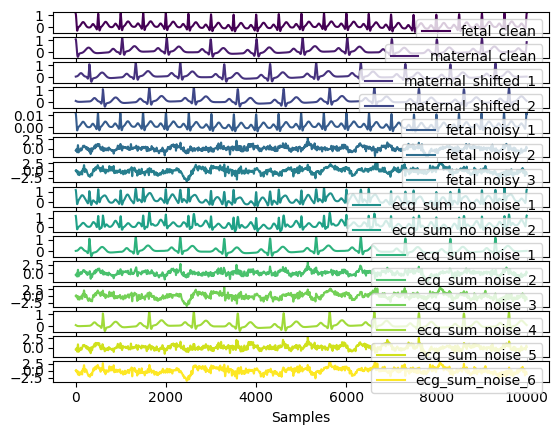

In [38]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=10, noise=0, heart_rate=60, sampling_rate=1000)

# Introduce noise to the fetal ECG signals
fetal_noisy_1 = 0.01 * nk.ecg_simulate(duration=10, noise=0, heart_rate=120, sampling_rate=1000)
fetal_noisy_2 = 0.1 * nk.ecg_simulate(duration=10, noise=10, heart_rate=120, sampling_rate=1000)
fetal_noisy_3 = 0.1 * nk.ecg_simulate(duration=10, noise=15, heart_rate=120, sampling_rate=1000)

# Shift the maternal ECG to simulate fetal ECG at different delays
maternal_shifted_1 = np.roll(maternal_clean, 300)
maternal_shifted_2 = np.roll(maternal_clean, 600)

# Combine fetal and maternal ECG signals without noise
ecg_sum_no_noise_1 = fetal_clean + maternal_shifted_1
ecg_sum_no_noise_2 = fetal_clean + maternal_shifted_2

# Combine noisy fetal ECG signals with maternal ECG
ecg_sum_noise_1 = fetal_noisy_1 + maternal_shifted_1
ecg_sum_noise_2 = fetal_noisy_2 + maternal_shifted_1
ecg_sum_noise_3 = fetal_noisy_3 + maternal_shifted_1
ecg_sum_noise_4 = fetal_noisy_1 + maternal_shifted_2
ecg_sum_noise_5 = fetal_noisy_2 + maternal_shifted_2
ecg_sum_noise_6 = fetal_noisy_3 + maternal_shifted_2

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
        "maternal_shifted_1": maternal_shifted_1,
        "maternal_shifted_2": maternal_shifted_2,
        "fetal_noisy_1": fetal_noisy_1,
        "fetal_noisy_2": fetal_noisy_2,
        "fetal_noisy_3": fetal_noisy_3,
        "ecg_sum_no_noise_1": ecg_sum_no_noise_1,
        "ecg_sum_no_noise_2": ecg_sum_no_noise_2,
        "ecg_sum_noise_1": ecg_sum_noise_1,
        "ecg_sum_noise_2": ecg_sum_noise_2,
        "ecg_sum_noise_3": ecg_sum_noise_3,
        "ecg_sum_noise_4": ecg_sum_noise_4,
        "ecg_sum_noise_5": ecg_sum_noise_5,
        "ecg_sum_noise_6": ecg_sum_noise_6
    })

# Calculate and print the kurtosis of each column in ecg_df
kurtosis_values = ecg_df.apply(stats.kurtosis)
print("Kurtosis values:")
print(kurtosis_values)

# Visualize the ECG signals with a larger figure
plt.figure(figsize=(15, 20))
nk.signal_plot(ecg_df, subplots=True)
plt.show()


In [32]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# Generate ECG data with different configurations
fetal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=120, sampling_rate=1000)
maternal_clean = nk.ecg_simulate(duration=6, noise=0, heart_rate=60, sampling_rate=1000)

# Create a DataFrame for visualization
ecg_df = pd.DataFrame(
    {
        "fetal_clean": fetal_clean,
        "maternal_clean": maternal_clean,
    })


# Correlation Coefficient
correlation = np.corrcoef(ecg_df['fetal_clean'], ecg_df['maternal_clean'])[0, 1]
print(f'Correlation coefficient between fetal clean and maternal clean ECG: {correlation}')

# Discretize the data into bins
bins = 10000
fetal_clean_binned = pd.cut(ecg_df['fetal_clean'], bins, labels=False)
maternal_clean_binned = pd.cut(ecg_df['maternal_clean'], bins, labels=False)

# Calculate Mutual Information on binned data
mutual_info = mutual_info_score(fetal_clean_binned, maternal_clean_binned)
print(f'Mutual information between fetal clean and maternal clean ECG: {mutual_info}')




Correlation coefficient between fetal clean and maternal clean ECG: 0.22077229366021076
Mutual information between fetal clean and maternal clean ECG: 7.0634548907865415
